In [32]:
%pip install gensim
%pip install nltk
%pip install keybert
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import pathlib
import multiprocessing
from keybert import KeyBERT

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befor

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


In [33]:
from enum import Enum
import pandas as pd
import re
import numpy as np

class Data(Enum):
    MOVIES = "movie.metadata.tsv"
    PLOTS = "plot_summaries.txt"
    NAME_CLUSTERS = "name.clusters.txt"

def load_data(type : Data, columns, index_col = ""):
    """
    Loads data of type using the Data Enum, with columns, and index_col as the index if provided. The data must be in a folder named MovieSummaries.

    returns: DataFrame
    """
    return pd.read_csv(
        #f'./rawdata/MovieSummaries/{type.value}',
        f'MovieSummaries/{type.value}', 
        sep="\t", 
        names=columns,
        index_col=index_col if index_col != "" else columns[0]
    )

orig_movie_df = load_data(
    Data.MOVIES, 
    ["wiki_id", "freebase_id", "name", "release_date", "revenue", "runtime", "languages", "countries", "genres"],
)
plot_df = load_data(
    Data.PLOTS, 
    ["wiki_id", "plot"]
)

In [34]:
def parse_multi_values(x): 
    """
    Parses the multi value structure of the dataset format into a sorted array of items
    Returns null values for empty lists as NaN (so all missing values we use are NaN)
    
    returns: array of strings extracted from x
    """
    if not x: 
        return []
    x = x.split(',')
    result = []
    for combo in x: 
        combo = combo.split(":")
        if len(combo) > 1: 
            combo[1] = re.sub("[^a-zA-Z0-9\s]+", "", combo[1])
            combo[1] = re.sub("^\s", "", combo[1])
            combo[1] = combo[1].strip()
            result.append(combo[1])
    if not result:
        return []
    return sorted(result)

def parse_language(languages):
    """
    Parses the language column specifically by removing "Langauge" from each entry

    returns: list of strings of the languages
    """
    if not languages or type(languages) != list:
        return []
    return list(map(lambda l : l.replace("Language", "").strip(), languages))

def parse_date(x):
    """
    Parses the date format into an int representing only the year. Values with missing entries are given NaN.

    returns: string representing the year 
    """
    if not x or x == np.nan:
        return np.NaN
    return str(x).split("-")[0]

def data_clean_movies(df):
    # Add plot summaries to the movie dataframe
    df = df.join(plot_df)

    # Parse multi value attributes into arrays
    for attribute in ["languages", "countries", "genres"]:
        df[attribute] = df[attribute].apply(parse_multi_values)

    # Remove "Language" from language column
    df["languages"] = df["languages"].apply(parse_language)

    # Parse release-date to all use the year as an int (don't need increased granularity right now)
    df["release_date"] = df["release_date"].apply(parse_date)

    # Replace missing numeric values with zero and convert to int rather than float
    for col in ["runtime", "revenue"]:
        df[col] = df[col].fillna(0)
        df[col] = df[col].astype(int)
    
    return df

# Create df that is cleaned
movie_df = data_clean_movies(orig_movie_df)

In [35]:
import string

def parseDocument(doc):
        """
        Parses a string into a format that is more suitable for later NLP applications.

        returns: parsed string
        """
        return word_tokenize(
                doc
                .lower()
                # Remove certain special characters
                .replace('\n', '')
                .replace('\r', '')
                # Remove punctuation and special characters
                .translate(str.maketrans('', '', string.punctuation))
        )

# Create new df where we remove all rows with missing plots
plot_removed = data_clean_movies(orig_movie_df)
plot_removed =  plot_removed[plot_removed['plot'].notna()]

In [47]:
plot_removed.head()

,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,plot
wiki_id,,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001,14010832,98,[English],[United States of America],"[Action, Adventure, Horror, Science Fiction, S...","Set in the second half of the 22nd century, th..."
9363483,/m/0285_cd,White Of The Eye,1987,0,110,[English],[United Kingdom],"[Erotic thriller, Psychological thriller, Thri...",A series of murders of rich young women throug...
261236,/m/01mrr1,A Woman in Flames,1983,0,106,[German],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."
18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,0,86,[English],[South Africa],"[Adventure, Family Film, Fantasy, World cinema]","Every hundred years, the evil Morgana returns..."
6631279,/m/0gffwj,Little city,1997,0,93,[English],[United States of America],"[Comedy, Comedydrama, Drama, Ensemble Film, Ro...","Adam, a San Francisco-based artist who works a..."


In [95]:
key_word_df = pd.read_csv('./plot_removed.csv')

In [96]:
key_word_df.head(5)

,wiki_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,plot,keyword
0,9363483,/m/0285_cd,White Of The Eye,1987.0,0,110,['English'],['United Kingdom'],"['Erotic thriller', 'Psychological thriller', ...",A series of murders of rich young women throug...,"[('joan', 0.4316), ('murders', 0.4232), ('mike..."
1,261236,/m/01mrr1,A Woman in Flames,1983.0,0,106,['German'],['Germany'],['Drama'],"Eva, an upper class housewife, becomes frustra...","[('eva', 0.4762), ('dominatrix', 0.4344), ('ho..."
2,171005,/m/016ywb,Henry V,1989.0,10161099,137,['English'],['United Kingdom'],"['Costume drama', 'Drama', 'Epic', 'Film adapt...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,"[('henry', 0.5294), ('treaty', 0.4244), ('nego..."
3,18296435,/m/04cqrs4,Aaah Belinda,1986.0,0,0,['Turkish'],['Turkey'],['Comedy'],"Serap, a young actress with a strong, lively p...","[('belinda', 0.5321), ('serap', 0.4993), ('sha..."
4,11250635,/m/02r52hc,The Mechanical Monsters,NaN,0,0,['English'],['United States of America'],"['Action', 'Adventure', 'Animation', 'Family F...",The story starts as one of the robots flies i...,"[('superman', 0.4893), ('lois', 0.4282), ('rob..."


In [97]:
a = key_word_df.iloc[0]['keyword']
a

"[('joan', 0.4316), ('murders', 0.4232), ('mike', 0.4111), ('detective', 0.3623), ('killer', 0.3547), ('killing', 0.3219), ('suspicions', 0.2954), ('kill', 0.2842), ('paul', 0.283), ('deer', 0.2782), ('adultery', 0.277), ('shoots', 0.2759), ('hunting', 0.2743), ('brutally', 0.273), ('mendoza', 0.2706), ('charles', 0.2621), ('gun', 0.2568), ('talks', 0.25), ('couple', 0.2495), ('married', 0.2463), ('clues', 0.2421), ('victims', 0.2419), ('reveals', 0.2407), ('seduced', 0.2402), ('rich', 0.2351), ('her', 0.2342), ('husband', 0.2305), ('him', 0.23), ('elude', 0.2274), ('destructive', 0.2266)]"

In [98]:
def filter_keywords(kw_str):    
    kw_str = kw_str.replace('\'', '') # '(', ')', '\"', '[', ']'
    kw_str = kw_str.replace('(', '') 
    kw_str = kw_str.replace(')', '')
    kw_str = kw_str.replace('\"', '')
    kw_str = kw_str.replace('[', '')
    kw_str = kw_str.replace(']', '')
    kw_str = kw_str.replace(' ', '')
    kw_str = kw_str.split(',')
    new_list = []
    for count in range(len(kw_str)):
        if count % 2 == 0:
            new_list.append(kw_str[count])
    return new_list
    
def convert_keywords_to_string(keyword_list):
    keyword_string = ""
    for item in keyword_list:
        keyword_string += item + " "
    return keyword_string

In [99]:
keyword = key_word_df.iloc[0]['keyword']
a_list = filter_keywords(keyword)
a_list

['joan',
 'murders',
 'mike',
 'detective',
 'killer',
 'killing',
 'suspicions',
 'kill',
 'paul',
 'deer',
 'adultery',
 'shoots',
 'hunting',
 'brutally',
 'mendoza',
 'charles',
 'gun',
 'talks',
 'couple',
 'married',
 'clues',
 'victims',
 'reveals',
 'seduced',
 'rich',
 'her',
 'husband',
 'him',
 'elude',
 'destructive']

In [100]:
key_word_df['keyword'] = key_word_df['keyword'].apply(filter_keywords)

In [101]:
key_word_df['keyword'] = key_word_df['keyword'].apply(convert_keywords_to_string)

In [102]:
key_word_df.head(5)

,wiki_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,plot,keyword
0,9363483,/m/0285_cd,White Of The Eye,1987.0,0,110,['English'],['United Kingdom'],"['Erotic thriller', 'Psychological thriller', ...",A series of murders of rich young women throug...,joan murders mike detective killer killing sus...
1,261236,/m/01mrr1,A Woman in Flames,1983.0,0,106,['German'],['Germany'],['Drama'],"Eva, an upper class housewife, becomes frustra...",eva dominatrix housewife prostitute sado penth...
2,171005,/m/016ywb,Henry V,1989.0,10161099,137,['English'],['United Kingdom'],"['Costume drama', 'Drama', 'Epic', 'Film adapt...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,henry treaty negotiations troyes catherine uni...
3,18296435,/m/04cqrs4,Aaah Belinda,1986.0,0,0,['Turkish'],['Turkey'],['Comedy'],"Serap, a young actress with a strong, lively p...",belinda serap shampoo actress naciye housewife...
4,11250635,/m/02r52hc,The Mechanical Monsters,NaN,0,0,['English'],['United States of America'],"['Action', 'Adventure', 'Animation', 'Family F...",The story starts as one of the robots flies i...,superman lois robot robots machine clark plane...


In [103]:
# First, we tokenize all plot summaries
tokenized_df = key_word_df.copy()
tokenized_summaries = tokenized_df['keyword'].values
tokenized_summaries = [TaggedDocument(parseDocument(doc), [idx]) for idx, doc in enumerate(tokenized_summaries)]

In [105]:
def create_doc2vec_model(documents, force_train_new = False):
    """
    Loads existing model from disk if available else trains new model.
    Set force_train_new to True to train a new model even if a previous model exists.
    
    returns: trained Doc2Vec model
    """

    fname = str(pathlib.Path().resolve()) + "/keyBERTdoc2vec_model"
    if not force_train_new:
        # Try to load, if it succeeds then previous model existed so return that one
        try:
            return Doc2Vec.load(fname)
        except:
            print("Failed to load existing model")

    # Train model
    print("Start training of Doc2Vec model...")
    model = Doc2Vec(
        documents, 
        window=2, 
        min_count=1, 
        workers=multiprocessing.cpu_count(), 
        epochs = 100
    )
    
    # Persist the model
    print(f"Finished training Doc2Vec, saving it to file {fname}")
    model.save(fname)
    return model

# Train the doc2vec model
model = create_doc2vec_model(tokenized_summaries, force_train_new=False)

Start training of Doc2Vec model...
Finished training Doc2Vec, saving it to file /Users/axelandersson/Documents/Teknik/ada-2022-project-adawizardry/keyBERTdoc2vec_model


In [124]:
apollo_wiki = """Apollo 13 (April 11–17, 1970) was the seventh crewed mission in the Apollo space program and the third meant to land on the Moon. The craft was launched from Kennedy Space Center on April 11, 1970, but the lunar landing was aborted after an oxygen tank in the service module (SM) failed two days into the mission. The crew instead looped around the Moon and returned safely to Earth on April 17. The mission was commanded by Jim Lovell, with Jack Swigert as command module (CM) pilot and Fred Haise as Lunar Module (LM) pilot. Swigert was a late replacement for Ken Mattingly, who was grounded after exposure to rubella.

A routine stir of an oxygen tank ignited damaged wire insulation inside it, causing an explosion that vented the contents of both of the SM's oxygen tanks to space. Without oxygen, needed for breathing and for generating electric power, the SM's propulsion and life support systems could not operate. The CM's systems had to be shut down to conserve its remaining resources for reentry, forcing the crew to transfer to the LM as a lifeboat. With the lunar landing canceled, mission controllers worked to bring the crew home alive.

Although the LM was designed to support two men on the lunar surface for two days, Mission Control in Houston improvised new procedures so it could support three men for four days. The crew experienced great hardship, caused by limited power, a chilly and wet cabin and a shortage of potable water. There was a critical need to adapt the CM's cartridges for the carbon dioxide scrubber system to work in the LM; the crew and mission controllers were successful in improvising a solution. The astronauts' peril briefly renewed public interest in the Apollo program; tens of millions watched the splashdown in the South Pacific Ocean on television.

An investigative review board found fault with preflight testing of the oxygen tank and Teflon being placed inside it. The board recommended changes, including minimizing the use of potentially combustible items inside the tank; this was done for Apollo 14. The story of Apollo 13 has been dramatized several times, most notably in the 1995 film Apollo 13 – based on Lost Moon, the 1994 memoir co-authored by Lovell – and an episode of the 1998 miniseries From the Earth to the Moon."""

# kw_model = KeyBERT()
# apollo_kw_keybert_format = kw_model.extract_keywords(apollo_wiki, keyphrase_ngram_range=(1, 1), top_n=30)
# apollo_kw_list = []
# for item in apollo_kw_keybert_format:
#     apollo_kw_list.append(item[0])
# print(apollo_kw_list)
# apollo_kw = convert_keywords_to_string(apollo_kw_list)
# Use the model to create a vectorized representation of the event text
test_doc = parseDocument(apollo_wiki)
test_vector = model.infer_vector(test_doc)

# Compare the event vector against all vectors of the movie summaries and extract the top 10 most similar ones
top_similar = model.dv.most_similar(positive=[test_vector],topn=1300)

# Create a df from this and merge with movie_df so we can get some movie information
top_similar_df = pd.DataFrame(top_similar, columns=["id", "similarity"]).set_index("id")
plot_removed = plot_removed.reset_index(drop=True)
top_similar_df = pd.merge(top_similar_df, key_word_df, left_index=True, right_index=True)[["name", "similarity", "release_date", "plot", "keyword"]]
top_similar_df

,name,similarity,release_date,plot,keyword
3041,Transformers: Dark of the Moon,0.538619,2011.0,"In 1961, the Ark, a Cybertronian spacecraft c...",optimus autobots apollo nasa cybertron moon me...
11267,Saint Elmo – Hikari no Raihousha,0.507054,1986.0,{{Expand section}} Japan builds a large space ...,elmo solar planet power mercury energy earth j...
6903,The Transformers: The Movie,0.498731,1986.0,"Unicron, a roaming artificial planet, devours...",autobots cybertron autobot decepticon deceptic...
7691,Star Trek: Generations,0.492660,1994.0,"In the year 2293, recently retired Captain Jam...",kirk starship solar supernova uss enterprise c...
8795,Humanity's End,0.491587,2009.0,"Several hundred years into the future, mankind...",nephilim species sapiens breeders technis race...
...,...,...,...,...,...
13104,Rio Rattler,0.256537,1935.0,A dying Marshal gives his identification paper...,marshal tom rattler murder killer chief mason ...
6960,The Hare-Brained Hypnotist,0.256522,1942.0,Elmer is reading a book about hypnotism but he...,elmer bugs rabbit chirping chewing carrots hyp...
1054,Box of Death,0.256414,1955.0,An anti-communist film about a plot to stir up...,communist film synopsis village plot camp terr...
8261,Yellow Submarine,0.256381,1968.0,"At the beginning of the story, Pepperland is i...",ringo pepperlanders pepperland pepper beatles ...


In [125]:
top_similar_df[top_similar_df.name == 'Apollo 13']

,name,similarity,release_date,plot,keyword


In [126]:
movie_df[movie_df.name == 'Apollo 13']

,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,plot
wiki_id,,,,,,,,,
142417,/m/011yd2,Apollo 13,1995,355237933,140,[English],[United States of America],"[Adventure, Drama, History]","On July 20, 1969, veteran astronaut Jim Lovell..."


In [127]:
top_similar_df.head(5)

,name,similarity,release_date,plot,keyword
3041,Transformers: Dark of the Moon,0.538619,2011.0,"In 1961, the Ark, a Cybertronian spacecraft c...",optimus autobots apollo nasa cybertron moon me...
11267,Saint Elmo – Hikari no Raihousha,0.507054,1986.0,{{Expand section}} Japan builds a large space ...,elmo solar planet power mercury energy earth j...
6903,The Transformers: The Movie,0.498731,1986.0,"Unicron, a roaming artificial planet, devours...",autobots cybertron autobot decepticon deceptic...
7691,Star Trek: Generations,0.492660,1994.0,"In the year 2293, recently retired Captain Jam...",kirk starship solar supernova uss enterprise c...
8795,Humanity's End,0.491587,2009.0,"Several hundred years into the future, mankind...",nephilim species sapiens breeders technis race...


array([[<AxesSubplot:title={'center':'similarity'}>]], dtype=object)

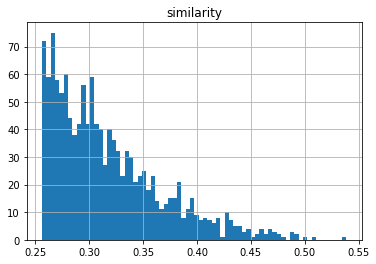

In [130]:
top_similar_df.hist(column = 'similarity', bins=70)